In [1]:
%matplotlib inline

import numpy as np
from numpy import random
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import itertools
import seaborn as sns
import os
import sys
Path = os.getcwd()
sys.path.append(Path)
from build_network import *
from utilities1 import simulated_SNR, psd, psd_Vm, save_figure




              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 19 2024 15:53:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
def plot_results(sim_time=5000, noisy=False, delay_mean=1.0, delay_sd=0.25,  
                 adjust_amp=False, adjust_thresh=False, second_sine=False,xLim=1, y_min=1e-12,
                 a_values=[100], SD_values=[250], f_values=[12], beat=2, E_m=-60, V_th=-50,
                 bin_size=1,seed=np.random.randint(0,1e+6), resolution=1.0, num_A=100,
                 print_f=True, log=True, harmonics=1, harmonics_beat=0, save_fig=False, V_thresh=-50,
                 measure_from_A=False, seed_check=False, weight=1, zoom=False, plot_isi=False):

    
    ###*************************SIMULATION**************************************
    tau_m = 10
    E_m_si = E_m*1e-3
    V_target_si = -55*1e-3 - E_m_si #dette gir <10mV, som er endringen vi ønsker 
    tau_si = 10*1e-3 #s
    R_si = 0.1*1e+9 #ohm
    mean_list = []

    
    if noisy:
        if adjust_amp or adjust_thresh:
            param_combos = list(itertools.product(f_values, SD_values))
        else:
            param_combos = list(itertools.product(f_values,a_values, SD_values))
    else:
        if adjust_amp or adjust_thresh:
             param_combos = list(itertools.product(f_values))
        else:
            param_combos = list(itertools.product(f_values, a_values))
    
    param_combos = np.atleast_1d(param_combos) #to allow for one single combination
    
        
    
    if zoom:
         fig, axes = plt.subplots(nrows=len(param_combos), ncols=4, 
                             figsize=(15, 4*len(param_combos)))
    else:
        fig, axes = plt.subplots(nrows=len(param_combos), ncols=3, 
                             figsize=(15, 4*len(param_combos)))
    
    if len(param_combos) == 1:
        axes = np.array([axes])
    
    for idx, combo  in enumerate(param_combos):
        if noisy:
            if adjust_amp:
                f, sd = combo
                a_si = V_target_si * math.sqrt(1 + (2*math.pi*(f)*tau_si)**2) / R_si
                a = a_si/(1e-12)
            else:
                if adjust_thresh:
                    f, sd = combo
                    a_unadj_si = V_target_si / R_si
                    a = a_unadj_si/(1e-12)
                    
                    V_th_si = (a_unadj_si * R_si) / (math.sqrt(1 + (2*math.pi*f*tau_si)**2 ))
                    V_th = (V_th_si+E_m_si)/(1e-3)
                else:
                    f, a, sd = combo
                    
            if second_sine:
                results = build_network(sim_time=sim_time, noisy=True, second_sine=True, V_thresh=V_th,
                                        f1=f, beat=beat, a=a, SD=sd, tau_m=tau_m, num_A=num_A,
                                        seed=seed, resolution=resolution, measure_from_A=measure_from_A, 
                                        weight=weight, delay_mean=delay_mean, delay_sd=delay_sd)                    
            else:
                results = build_network(sim_time=sim_time, noisy=True,delay_mean=delay_mean, delay_sd=delay_sd,
                f1=f, a=a, SD=sd, second_sine=second_sine, tau_m=tau_m, num_A=num_A, V_thresh=V_th, 
                                        seed=seed, resolution=resolution, measure_from_A=measure_from_A,
                                        weight=weight)
            
        else:
            if adjust_amp:
                (f,) = combo
                a_si = V_target_si * math.sqrt(1 + (2*math.pi*f*tau_si)**2) / R_si
                a = a_si/(1e-12)
                
            elif adjust_thresh:
                (f,) = combo
                a_unadj_si = V_target_si / R_si
                a = a_unadj_si/(1e-12)
                    
                V_th_si = (a_unadj_si * R_si) / (math.sqrt(1 + (2*math.pi*f*tau_si)**2 ))
                V_th = (V_th_si+E_m_si)/(1e-3)
            else:
                f,a = combo
                
            if second_sine:
                results = build_network(sim_time=sim_time, noisy=False, second_sine=True, delay_mean=delay_mean, delay_sd=delay_sd,
                                        f1=f, V_thresh=V_th, beat=beat, a=a, SD=0, tau_m=tau_m, num_A=num_A, 
                                        seed=seed, resolution=resolution, measure_from_A=measure_from_A, weight=weight)
            else:
                results = build_network(sim_time=sim_time, second_sine=second_sine, noisy=noisy, 
                                        f1=f, a=a, delay_mean=delay_mean, delay_sd=delay_sd, 
                                        V_thresh=V_th, E_m=E_m, tau_m=tau_m, num_A=num_A, 
                                        seed=seed, beat=beat, resolution=resolution, measure_from_A=measure_from_A, weight=weight)
                #results = build_network(a1=a, a2=a, f1=f, seed=42, beat=20, SD=179, sim_time=10000, noisy=True)
                
         #********************************RESULTS AND PLOTS********************************   
        spike_times = results["spike_times"]
        Vm = results["Vm"]
        V_th = results["V_th"]
        sim_time = results["sim_time"]
        times = results["times"]
        tot_spike_rate = results["tot_spike_rate"]
    
            
        """--------test--------"""
        if noisy:
            std_Vm = np.std(Vm)
            std_Vm_corr = np.std(Vm - np.mean(Vm))

        
        
        # Layout
        sns.set_style("whitegrid")
        plt.rcParams["font.family"] = "Liberation Serif"
        
        # Membrane potential with threshold 
    
       
        ax_vm = axes[idx,0]
            
        time_axis = np.linspace(0,sim_time,len(Vm))
        
        for t in spike_times:
            ax_vm.vlines(x=t, ymin=V_th, ymax=V_th+5, color="black") 
            
        ax_vm.plot(times, Vm, color='#006D5B')
        ax_vm.axhline(V_th, linestyle='-', color='black', label="V_th")  # terskel-linje
        
        
        #-------------------SETTING TITLE-----------------------------
        letters = "ABCDEFGHIJKLMN"
        
        if noisy:
            if second_sine:
                ax_vm.set_title(
                rf"{letters[idx*3]}. Vm ($f_1$ = {f:.0f}Hz, $f_2$ = {f + beat :.0f}Hz, " +
                rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)",
                fontsize=16, fontweight='bold', color="#006D5B"
                )
            else:
                ax_vm.set_title(
                rf"{letters[3*idx]}. Vm ($f$ = {f:.0f}Hz, $\sigma_I$ = {sd:.0f}pA, " +
                rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)",
                fontsize=16, fontweight='bold', color="#006D5B"
                )
        else:
            if second_sine:
                ax_vm.set_title(
                rf"{letters[3*idx]}. Vm ($f_1$ = {f:.0f}Hz, $f_2$ = {f + beat:.0f}Hz, " +
                rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)",
                fontsize=16, fontweight='bold', color="#006D5B"
                )
            else:
                ax_vm.set_title(
                rf" Vm ($f$ = {f:.0f}Hz, $I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)",
                fontsize=16, fontweight='bold', color="#006D5B")
                
        if a == 0:
   
            title = title.replace(r"($f$ = " + f"{f:.0f}" + r"Hz, ", "(")
            title = title.replace(r"($f_1$ = " + f"{f:.0f}" + r"Hz, $f_2$ = " + f"{f + beat:.0f}" + r"Hz, ", "(")

            
        ax_vm.set_xlim([1000, 1000+xLim*1000])
        if np.all(Vm!=-60):
            ax_vm.set_ylim([np.min(Vm)-5,np.max(Vm)+10])
        else:
            ax_vm.set_ylim(np.min(Vm)-5, np.max(Vm)+10)
        ax_vm.set_xlabel("Time [ms]", color="#006D5B", fontsize=16)
        ax_vm.set_ylabel(r"$V_\mathrm{m}\, [\mathrm{mV}]$", color="#006D5B", fontsize=16)
        
        #chat-gpt:
        ax_vm.set_facecolor("#F5F5F5")
        ax_vm.spines["top"].set_visible(False)
        ax_vm.spines["right"].set_visible(False)
        ax_vm.spines["left"].set_color("#333333")
        ax_vm.spines["bottom"].set_color("#333333")
        ax_vm.xaxis.label.set_color("#006D5B")
        ax_vm.yaxis.label.set_color("#006D5B")
        ax_vm.tick_params(axis='both', colors="#333333")
        ax_vm.legend(facecolor="white", framealpha=1, edgecolor="#333333")
    
    
        freqs, psd_values = psd(spike_times, sim_time, bin_size)
        freqs = freqs[50:]
        psd_values = psd_values[50:]
        arg_f = np.argmin(np.abs(freqs - f))
        if second_sine:
            arg_beat = np.argmin(np.abs(freqs - beat))
        else:
            arg_beat = None
        
        
        
        ax_fft = axes[idx,1]
        
        
        
        # Vertical lines, colors filled in by chat GPT
        
        beat_colors = ["teal", "#1E3A8A", "#2563EB", "#60A5FA", "#38BDF8"] #Blue colors for beat frequencies
        colors = ["#009879", "#4CAF50", "#8BC34A", "#CDDC39", "#FFEB3B", "#FF9800","#F4E91E63","#9C27B0","#673AB7", 
    "#3F51B5"] # Green colors for harmonics
        
        for i in range(1,harmonics_beat+1):
            ax_fft.axvline(i*beat, linestyle="--", dashes=(2, 5), color=beat_colors[i], label=f"f={i*beat}Hz")
            
        for i in range(1,harmonics+1):
            ax_fft.axvline(i*f, linestyle="--", dashes=(2, 5), color=colors[i], label=f"{i*f}Hz")
            if second_sine:
                ax_fft.axvline(i*(f+beat), linestyle="--", dashes=(2, 5), color=colors[i+harmonics], label=f"{i*(f+beat)}Hz")
            ax_fft.legend()
        
        ax_fft.plot(freqs, psd_values, color="#006D5B") 
        
        xMax = max(f,np.max(freqs))*1.1
        if log:
            ax_fft.set_xscale("log")
            ax_fft.set_yscale("log")
            ax_fft.xaxis.set_major_locator(LogLocator(base=10.0))
            ax_fft.yaxis.set_major_locator(LogLocator(base=10.0))
            #ax_fft.set_ylim(1e-5,1e-3)
            
        ax_fft.set_xlabel("Frequency (Hz)", color="#006D5B", fontsize=16)
        ax_fft.set_ylabel(r'PSD [$\mathrm{spikes}^2/\mathrm{Hz}$]', color="#006D5B", fontsize=16)
        ax_fft.set_title(f"{letters[1+3*idx]}. PSD of spike train", fontsize=18, fontweight='bold', color="#006D5B")
        
        #generated by ChatGPT:
        ax_fft.set_facecolor("#F5F5F5")
        ax_fft.spines["top"].set_visible(False)
        ax_fft.spines["right"].set_visible(False)
        ax_fft.spines["left"].set_color("#333333")
        ax_fft.spines["bottom"].set_color("#333333")
        ax_fft.xaxis.label.set_color("#006D5B")
        ax_fft.yaxis.label.set_color("#006D5B")
        ax_fft.tick_params(axis='both', colors="#333333", labelsize='large')
        ax_fft.legend(facecolor="white", framealpha=1, edgecolor="#333333",loc='lower left')
        
        if zoom:
            
            ax_zoom = axes[idx,3]
            ax_zoom.plot(freqs, psd_values, color="#006D5B")
            for i in range(1,harmonics_beat+1):
                ax_zoom.axvline(i*beat, linestyle="--", dashes=(2, 5), color=beat_colors[i], label=f"f={i*beat}Hz")
            
            for i in range(1,harmonics+1):
                ax_zoom.axvline(i*f, linestyle="--", dashes=(2, 5), color=colors[i], label=f"{i*f}Hz")
                if second_sine:
                    ax_zoom.axvline(i*(f+beat), linestyle="--", dashes=(2, 5), color=colors[i+harmonics], label=f"{i*f}Hz")
            ax_fft.legend()
            ax_zoom.set_xlabel("Frequency (Hz)", color="#006D5B")
            ax_zoom.set_ylabel("PSD [Spike-rate/Hz]", color="#006D5B")
            ax_zoom.set_title(f"{letters[1+3*idx]}. PSD of spike train", fontsize=18, fontweight='bold', color="#006D5B")
            ax_zoom.set_xlim(0,100)
            ax_zoom.set_facecolor("#F5F5F5")
            ax_zoom.spines["top"].set_visible(False)
            ax_zoom.spines["right"].set_visible(False)
            ax_zoom.spines["left"].set_color("#333333")
            ax_zoom.spines["bottom"].set_color("#333333")
            ax_zoom.xaxis.label.set_color("#006D5B")
            ax_zoom.yaxis.label.set_color("#006D5B")
            ax_zoom.tick_params(axis='both', colors="#333333", labelsize='large')
            ax_zoom.legend(facecolor="white", framealpha=1, edgecolor="#333333")
            
        
        # table of important values
        if noisy:
            if second_sine == False:
                beat = 0
            df, noise_avg = simulated_SNR(Vm, a, psd_values, f, freqs, arg_f, 
                                          sim_time, sd, beat, spike_times, second_sine)
                      
            df["Population spike-rate"] = tot_spike_rate
            display(df)
    
    
        # FFT of membrane potential
        freqs, fft_vm = psd_Vm(Vm, times, bin_size)
        fft_vm = np.abs(fft_vm)
        
        ax_fft_vm = axes[idx,2]
        for i in range(1,harmonics_beat+1):
            ax_fft_vm.axvline(i*beat, linestyle="--", dashes=(2, 5), color=beat_colors[i], label=f"{i*beat}Hz")
            
        for i in range(1,harmonics+1):
            ax_fft_vm.axvline(i*f, linestyle="--", dashes=(2, 5), color=colors[i], label=f"{i*f}Hz")
            if second_sine:
                ax_fft_vm.axvline(i*(f+beat), linestyle="--", dashes=(2, 5), color=colors[i+harmonics], label=f"{i*(f+beat)}Hz")
            
       
        ax_fft_vm.legend()
            
        ax_fft_vm.plot(freqs, np.abs(fft_vm), color='#006D5B')  
        ymin = max(y_min, np.min(np.abs(fft_vm)))
        ax_fft_vm.set_ylim(ymin,10*np.max(np.abs(fft_vm)))
        ax_fft_vm.set_xlabel("Frequency [Hz]", color="#006D5B", fontsize=16)
        ax_fft_vm.set_ylabel(r'PSD [$(\mathrm{mV})^2/\mathrm{Hz}$]', color="#006D5B", fontsize=16)
        ax_fft_vm.set_title(f"{letters[2+3*idx]}. PSD of $V_m$", fontsize=20, fontweight='bold', color="#006D5B")
        if np.any(Vm!=-60): 
            ax_fft_vm.set_xscale("log")
            ax_fft_vm.set_yscale("log")
            ax_fft_vm.xaxis.set_major_locator(LogLocator(base=10.0))
            ax_fft_vm.yaxis.set_major_locator(LogLocator(base=10.0))
        
        #generated by chatGPT
        ax_fft_vm.set_facecolor("#F5F5F5")
        ax_fft_vm.spines["top"].set_visible(False)
        ax_fft_vm.spines["right"].set_visible(False)
        ax_fft_vm.spines["left"].set_color("#333333")
        ax_fft_vm.spines["bottom"].set_color("#333333")
        ax_fft_vm.xaxis.label.set_color("#006D5B")
        ax_fft_vm.yaxis.label.set_color("#006D5B")
        ax_fft_vm.tick_params(axis='both', colors="#333333", labelsize='large')
        ax_fft_vm.legend(facecolor="white", framealpha=1, edgecolor="#333333")
        
        
        if save_fig:
            save_dir = os.path.join(os.getcwd(), "results")
            os.makedirs(save_dir, exist_ok=True)
            file_index = 1
            while os.path.exists(os.path.join(save_dir, f"main_{file_index}.png")):
                file_index += 1
        
    if seed_check:
        plt.figure()
        plt.plot(results["times"], results["Vm"])
        plt.plot(results["times2"], results["Vm2"], linestyle="--")
        plt.xlim(100,500)
        plt.title("Making sure noise varies within the population")
    
    if plot_isi:
        plt.figure()
        ISI = np.diff(spike_times)
        plt.hist(ISI, bins=np.linspace(5, 200, 100))
        
        mods = spike_times % 1.0  # Tar spike times modulo 1 ms
        plt.figure()
        plt.hist(mods, bins=100, color="teal", edgecolor="black")
        plt.xlabel("Spike time modulo 1 ms", fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.title("Spike times modulo 1 ms", fontsize=14, fontweight="bold")
        plt.grid(True)
    
    plt.tight_layout()
    save_figure("B_main")
    plt.show()
        

Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


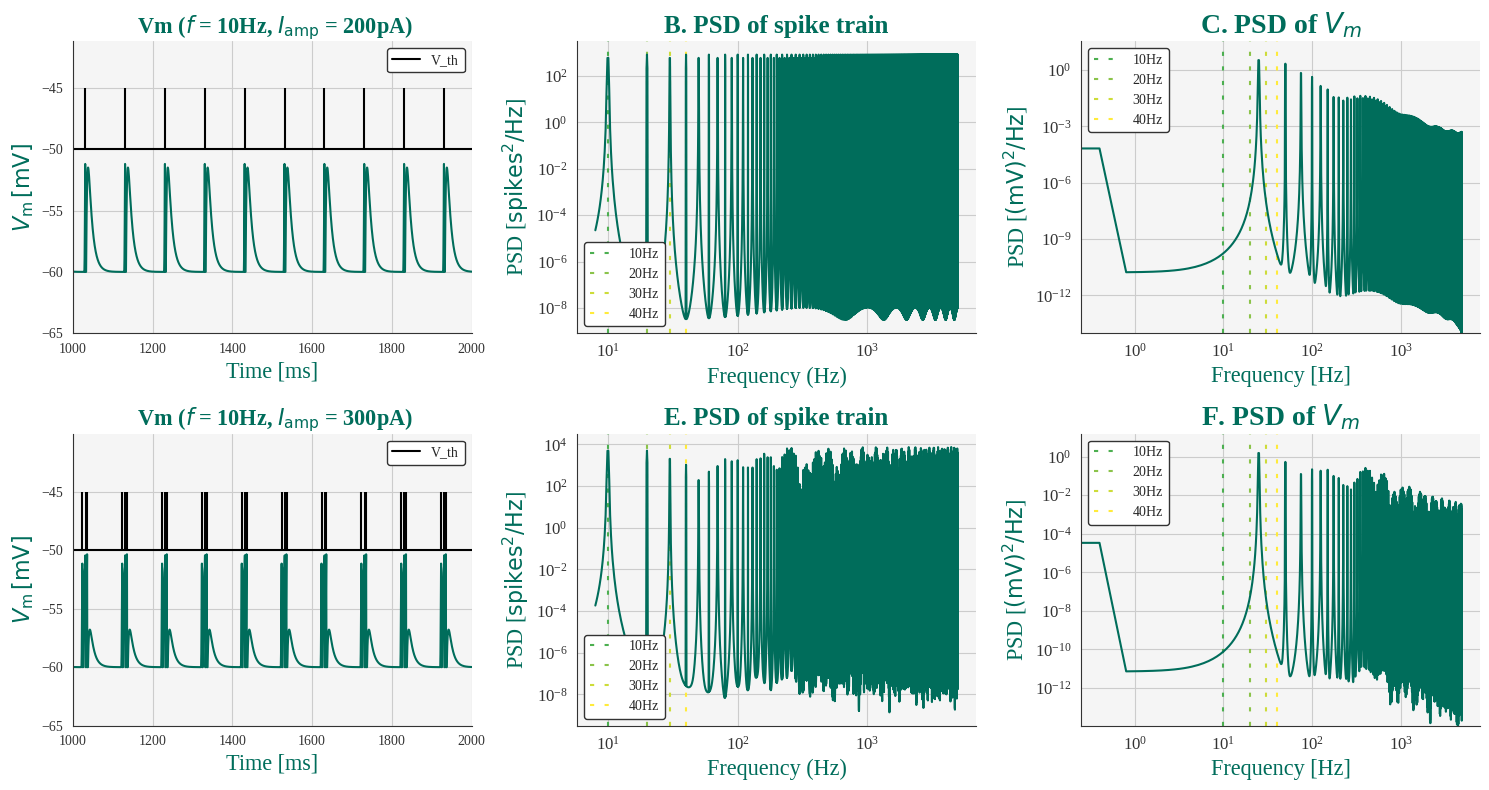

In [8]:
plot_results(sim_time=100e3, delay_sd=0.25, delay_mean=1,
             a_values=[200,300], V_th=-50, f_values=[10],
             noisy=False, SD_values=[0],num_A=1000, y_min=1e-15,
             bin_size=0.1,xLim=1,second_sine=False, harmonics=4,
            save_fig=True, log=True, resolution=0.25, weight=1)

10 FØRSTE FREQS [8.   8.16 8.32 8.48 8.64 8.8  8.96 9.12 9.28 9.44]
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


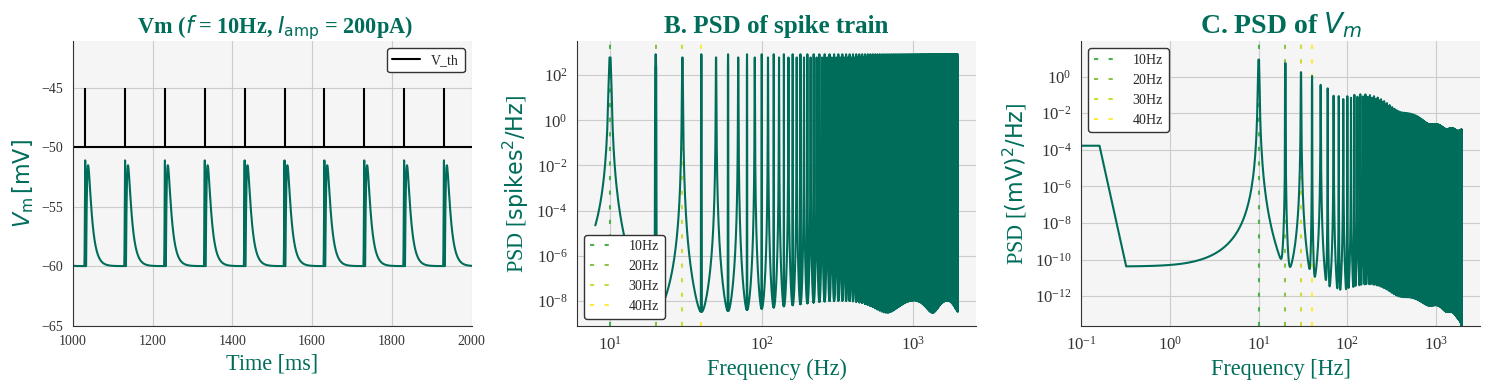

In [6]:
plot_results(sim_time=100e3, delay_sd=0.25, delay_mean=1,
             a_values=[200], V_th=-50, f_values=[10],
             noisy=False, SD_values=[0],num_A=1000, y_min=1e-15,
             bin_size=0.25,xLim=1,second_sine=False, harmonics=4,
            save_fig=True, log=True, resolution=0.25, weight=1)


May 15 09:03:56 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 0.25 ms

May 15 09:03:56 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.25 ms.
len psd values 12201, arg_f 12
noise_avg for f 3.83918983276899


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[10, 30]",20,100,-50.001582,19.35,19.35,19.05,9.92,5.04,3.84,1.99,5.2,3.7,4514.42


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


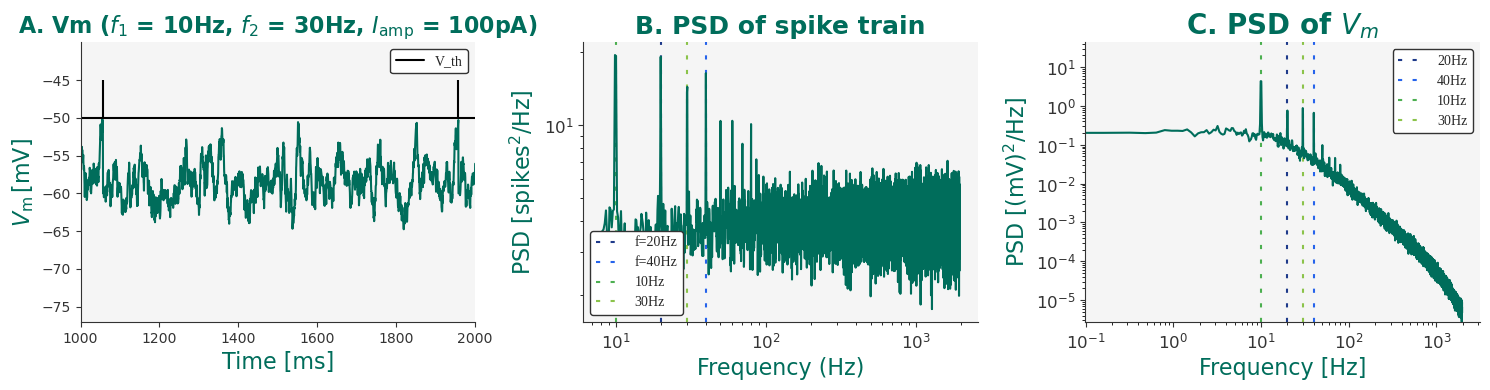

In [3]:
plot_results(sim_time=100e3,
             a_values=[100],f_values=[10], delay_sd=0.25, delay_mean=1,
             noisy=True, SD_values=[250],num_A=1000, seed=5,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=2,harmonics=1,
            save_fig=True, log=True, resolution=0.25, weight=1)

len psd values 12201, arg_f 575
noise_avg for f 4.582470993290594


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[100, 120]",20,400,-50.00016,31.79,8.41,31.79,20.0,1.84,4.58,2.42,7.1,4.5,7097.2


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


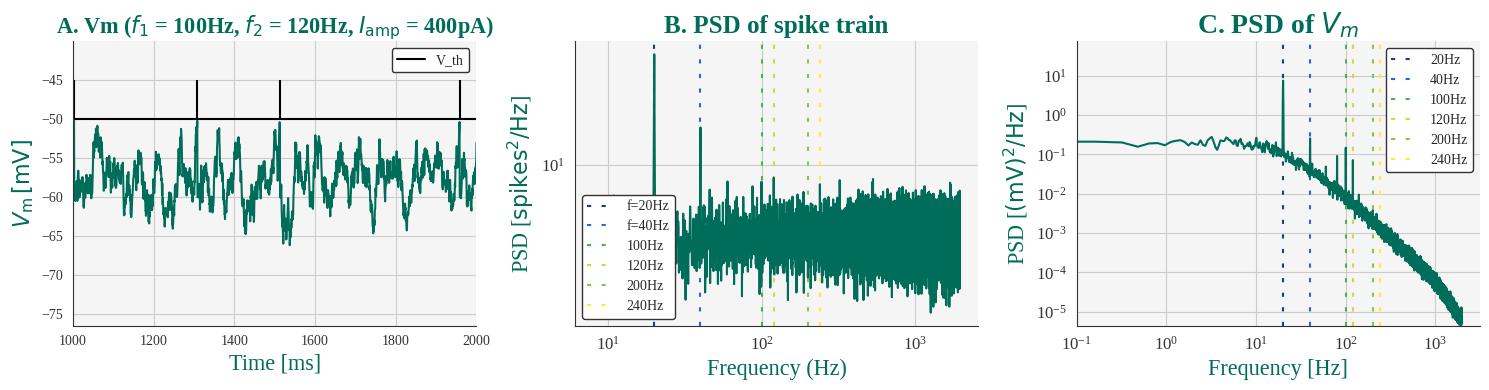

In [4]:
plot_results(sim_time=100e3,
             a_values=[400],f_values=[100], delay_sd=0.25, delay_mean=1,
             noisy=True, SD_values=[250],num_A=1000, seed=5,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=2,harmonics=2,
            save_fig=True, log=True, resolution=0.25, weight=1)


May 14 14:25:41 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 0.25 ms

May 14 14:25:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.25 ms.
delay: [1.08407949 0.65456555 0.92952305 1.38190787 1.222435   1.1823037
 1.39666623 1.10102088 1.02866616 1.30604502]
max V -50.010847341633145
I_syn_ex: 314.63004460479806
POPULATION SPIKE RATE: 6043.42
10 FØRSTE FREQS [8.   8.16 8.32 8.48 8.64 8.8  8.96 9.12 9.28 9.44]
len psd values 12201, arg_f 6200
noise_avg for f 0.43089887313566827


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,3000,-50.010847,0.75,0.55,0.42,748.16,1.27,0.43,0.25,0.9,0.4,6043.42


delay: [1.08944167 1.32797301 1.05852566 0.59188409 0.55661699 0.54615949
 1.13910279 0.75146096 0.95374594 0.77010594]
max V -50.004416875238974
I_syn_ex: 815.8994798192239
POPULATION SPIKE RATE: 9724.14
10 FØRSTE FREQS [8.   8.16 8.32 8.48 8.64 8.8  8.96 9.12 9.28 9.44]
len psd values 12201, arg_f 6200
noise_avg for f 0.8714259156842935


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,3500,-50.004417,1.52,1.07,1.32,383.2,1.23,0.87,0.48,1.4,0.9,9724.14


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


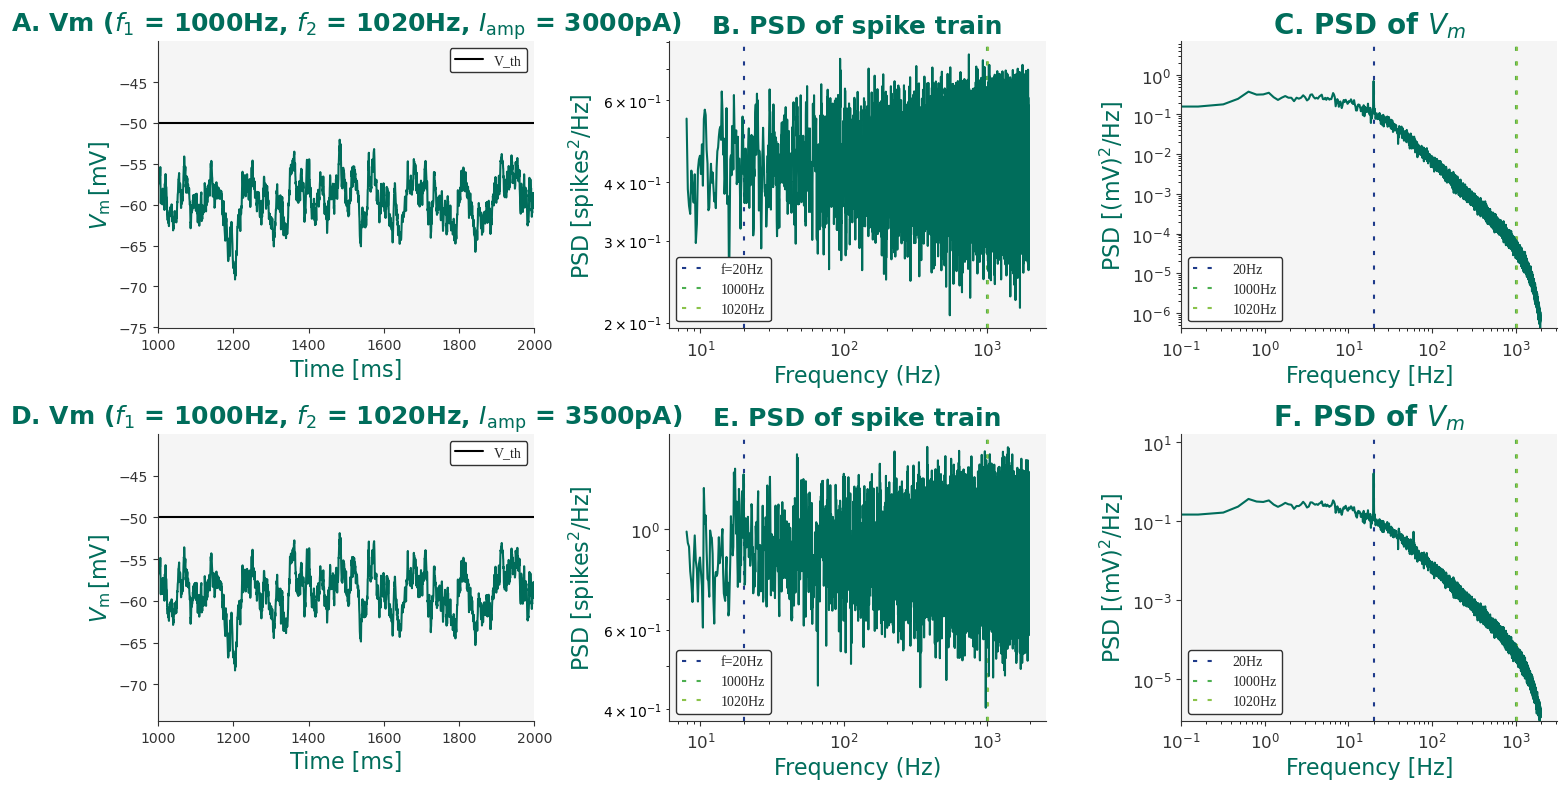

In [3]:
plot_results(sim_time=100e3,
             a_values=[3000,3500],f_values=[1000], delay_sd=0.25, delay_mean=1,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
            save_fig=True, log=True, resolution=0.25, weight=1)

delay: [6.7596955  3.94734812 6.56399587 6.74094232 7.01868303 6.39005426
 9.74595719 6.10713245 6.32362649 6.14749961]
max V -50.01206670851366
I_syn_ex: 149.1115745078694
POPULATION SPIKE RATE: 3343.17
10 FØRSTE FREQS [8.   8.16 8.32 8.48 8.64 8.8  8.96 9.12 9.28 9.44]
len psd values 12201, arg_f 6200
noise_avg for f 0.4646516804550169


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,2500,-50.012067,0.63,0.41,0.39,1846.4,0.88,0.46,0.23,0.8,0.5,3343.17


delay: [6.24599654 3.00765352 0.7398786  0.75180865 6.63628896 3.20805367
 5.11011042 2.41387295 8.13554949 7.30795348]
max V -50.00384664472059
I_syn_ex: 430.9150946754717
POPULATION SPIKE RATE: 6033.96
10 FØRSTE FREQS [8.   8.16 8.32 8.48 8.64 8.8  8.96 9.12 9.28 9.44]
len psd values 12201, arg_f 6200
noise_avg for f 2.004344045318926


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,3000,-50.003847,4.3,1.7,4.3,20.0,0.85,2.0,0.96,2.2,2.0,6033.96


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


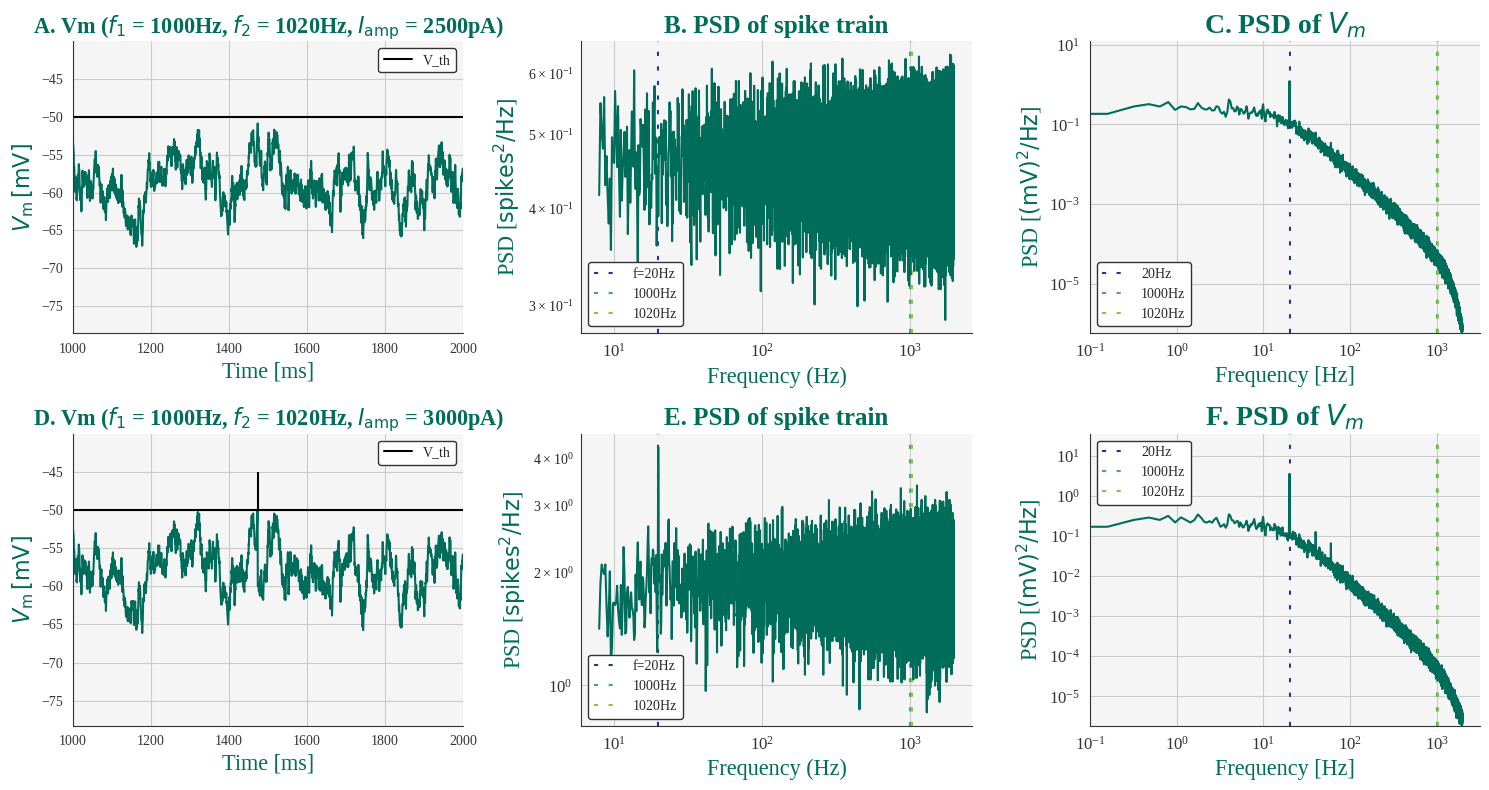

In [6]:
"""delay = 2ms. f=1000 og 1020"""
plot_results(sim_time=100e3,
             a_values=[2500, 3000],f_values=[1000], delay_sd=2, delay_mean=5,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
            save_fig=True, log=True, resolution=0.25, weight=1)

max V -50.0009002959835
I_syn_ex: 176.5612117266672
POPULATION SPIKE RATE: 3343.17
10 FØRSTE FREQS [8.   8.16 8.32 8.48 8.64 8.8  8.96 9.12 9.28 9.44]
len psd values 12201, arg_f 6200
noise_avg for f 0.44965416880191617


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,2500,-50.0009,0.68,0.41,0.38,1449.12,0.91,0.45,0.22,0.9,0.5,3343.17


max V -50.004255557773064
I_syn_ex: 565.653050576094
POPULATION SPIKE RATE: 6033.96
10 FØRSTE FREQS [8.   8.16 8.32 8.48 8.64 8.8  8.96 9.12 9.28 9.44]
len psd values 12201, arg_f 6200
noise_avg for f 1.9516784446049402


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,3000,-50.004256,4.72,1.86,4.72,20.0,0.95,1.95,1.0,2.5,1.9,6033.96


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


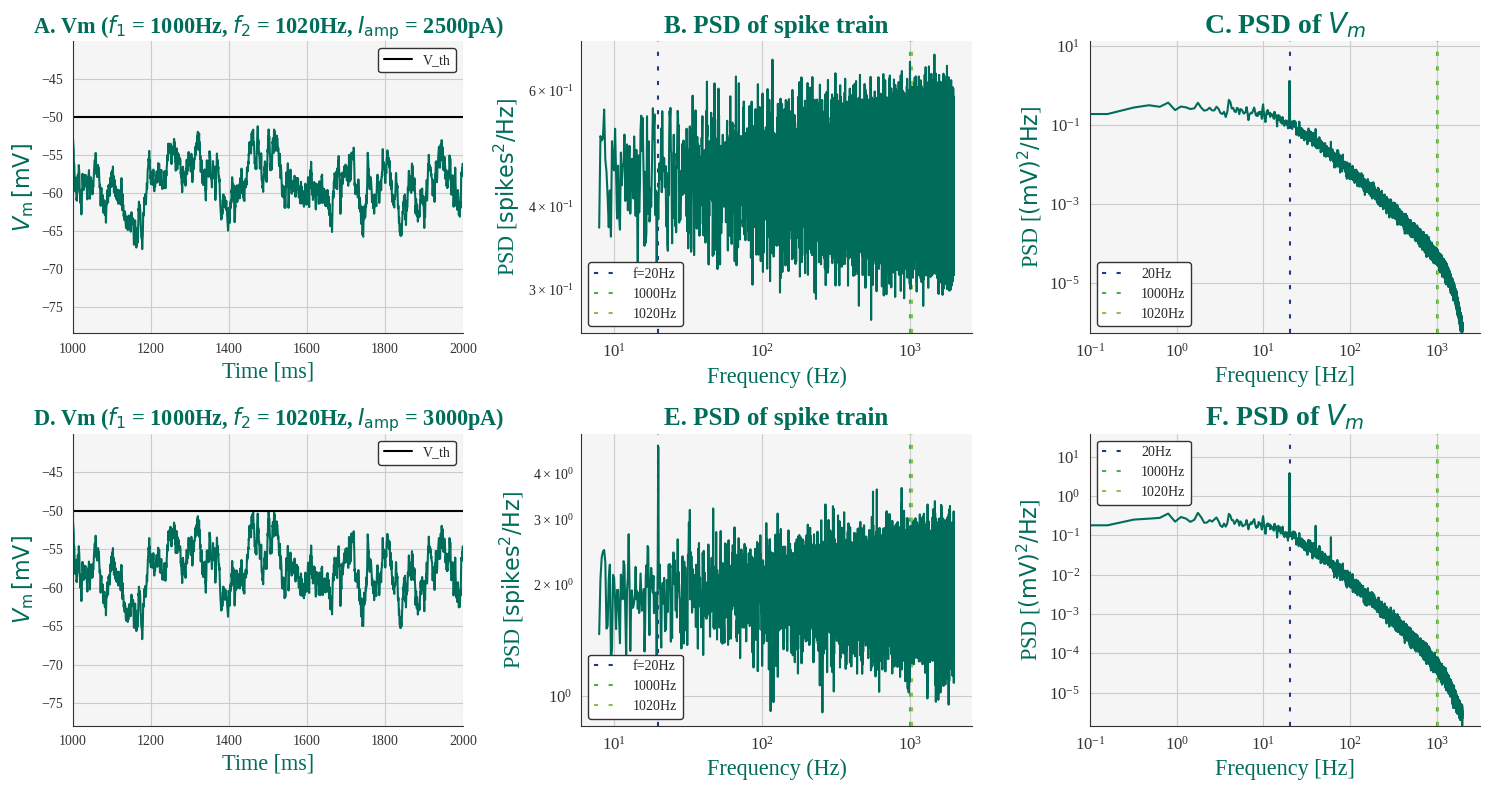

In [7]:
plot_results(sim_time=100e3,
             a_values=[2500, 3000],f_values=[1000], delay_sd=0, delay_mean=1,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
            save_fig=True, log=True, resolution=0.25, weight=1)

delay: [54.93386457 73.73840777 58.14736189 60.8699242  43.09680671 46.16755301
 45.34643488 59.8622648  35.05254857 37.39113996]
max V -50.000204246811386
I_syn_ex: 154.77307202230713
POPULATION SPIKE RATE: 6049.089999999999
10 FØRSTE FREQS [8.   8.16 8.32 8.48 8.64 8.8  8.96 9.12 9.28 9.44]
len psd values 12201, arg_f 6200
noise_avg for f 1.7109946595775722


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,3000,-50.000204,3.17,1.93,2.51,1201.6,1.13,1.71,0.82,1.5,1.7,6049.09


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


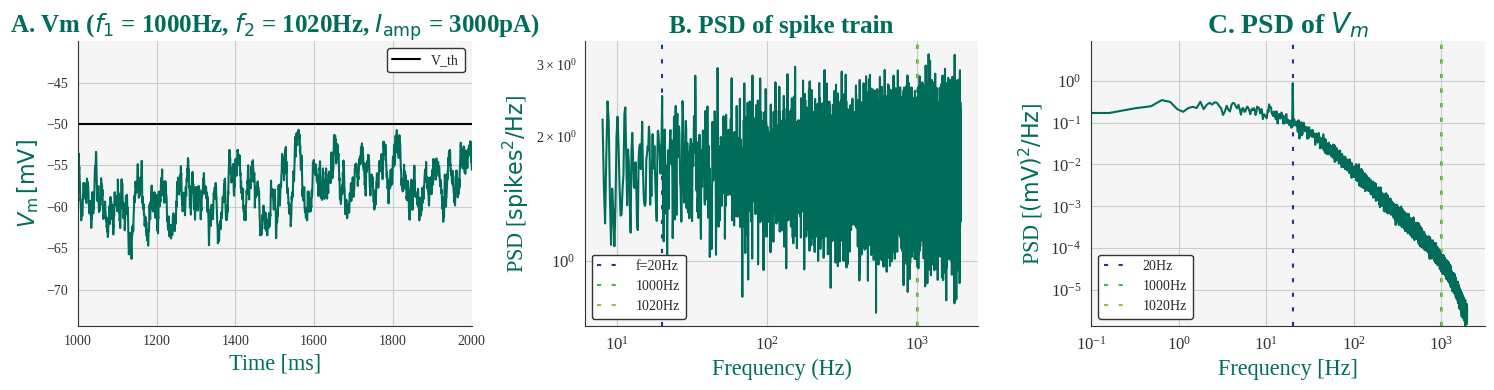

In [4]:
plot_results(sim_time=100e3,
             a_values=[3000],f_values=[1000], delay_sd=10, delay_mean=50,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
            save_fig=True, log=True, resolution=0.25, weight=1)